In [34]:
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style="darkgrid")
from datetime import datetime
import cvxpy as cp  
import scipy.optimize as sco
import numpy as np
from arch import arch_model
import empyrical as ep
from sklearn.covariance import LedoitWolf, MinCovDet
from pandas_datareader import data as wb
# %matplotlib inline

# Data Preparation

In [35]:
# set display options
pd.options.display.max_rows, pd.options.display.max_columns = 10, 25
stocks = pd.read_csv('all_stocks_5yr.csv')
stocks

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


In [36]:
stock_name = stocks[stocks.date == '2013-02-08'].Name.values
len(stock_name)

476

In [37]:
stocks['return'] = np.log(stocks['close']) - np.log(stocks['close'].shift())

drop = np.array([0])

for i in range(1,stocks.shape[0]): 
    if stocks['Name'][i] != stocks['Name'][i-1]:
        drop = np.append(drop, i)
    
    
    
stocks.drop(index=drop,inplace=True)

stocks

,date,open,high,low,close,volume,Name,return
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,-0.019857
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,-0.013227
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,0.026963
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,-0.046780
5,2013-02-15,13.93,14.61,13.93,14.50,15628000,AAL,0.035806
...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS,0.014106
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS,-0.013454
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS,-0.039179
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS,-0.007614


In [38]:
stocks = stocks.copy().loc[:,['date','Name','return']]
stocks

,date,Name,return
1,2013-02-11,AAL,-0.019857
2,2013-02-12,AAL,-0.013227
3,2013-02-13,AAL,0.026963
4,2013-02-14,AAL,-0.046780
5,2013-02-15,AAL,0.035806
...,...,...,...
619035,2018-02-01,ZTS,0.014106
619036,2018-02-02,ZTS,-0.013454
619037,2018-02-05,ZTS,-0.039179
619038,2018-02-06,ZTS,-0.007614


In [39]:
stocks = stocks.pivot(index='date', columns='Name', values='return')
stocks

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,...,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,
2013-02-11,-0.010705,-0.019857,-0.006485,0.010368,-0.011096,-0.002776,-0.004369,-0.003279,-0.012346,0.008281,0.001983,-0.009648,...,0.002250,0.003586,0.002476,-0.001334,-0.003731,-0.000700,0.003762,0.013566,-0.011552,-0.002640,0.002896,0.006334
2013-02-12,0.000448,-0.013227,0.002675,-0.025386,-0.012067,0.004268,0.001167,0.004097,0.006449,0.004115,0.017352,0.000331,...,0.003738,0.002145,0.003526,0.003198,0.002037,0.000700,-0.003762,0.017687,0.003094,-0.002780,0.011499,0.014329
2013-02-13,0.002909,0.026963,0.004696,-0.001905,-0.004244,-0.006838,0.004654,0.002586,-0.002059,-0.000216,0.011296,0.001490,...,0.011132,-0.002861,0.000352,0.005837,0.002371,0.004887,0.005013,0.011030,-0.005265,0.007396,0.010156,-0.005647
2013-02-14,-0.003806,-0.046780,-0.001648,-0.000900,0.036195,0.002783,0.006940,-0.005863,-0.005167,0.006035,0.007673,0.004786,...,-0.007407,-0.001075,-0.007062,0.016789,-0.001693,-0.003954,0.003743,0.007404,-0.008106,0.004464,-0.004456,-0.008381
2013-02-15,-0.053681,0.035806,0.002027,-0.013876,0.027244,-0.003641,0.010891,0.013986,0.000647,-0.007874,0.036584,0.007871,...,-0.034799,0.007857,0.015820,-0.008360,-0.001809,-0.002567,-0.007500,-0.006696,0.001564,-0.005780,-0.011844,0.021116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,-0.008205,-0.008133,0.002561,0.002088,0.036056,-0.003820,0.000322,-0.001495,-0.001904,-0.002506,-0.011474,-0.026308,...,0.010727,-0.018353,-0.001358,-0.007285,0.020072,-0.001316,-0.041274,0.035082,-0.007237,0.008382,0.017430,0.014106
2018-02-02,-0.021933,-0.033594,-0.029065,-0.044360,-0.010108,-0.033488,-0.007912,-0.022436,-0.018936,-0.028105,-0.024557,-0.015482,...,-0.021930,-0.007392,0.038917,-0.025852,-0.052316,-0.011094,-0.034797,0.010897,-0.016206,-0.018900,-0.015212,-0.013454
2018-02-05,-0.043457,-0.045954,-0.036377,-0.025302,-0.050393,-0.043855,-0.049171,-0.032847,-0.027832,-0.042525,-0.020237,-0.038691,...,-0.027782,-0.019295,-0.015014,-0.053352,-0.058586,-0.025634,-0.007935,-0.040459,-0.034849,-0.020967,-0.047268,-0.039179


In [40]:
stocks = stocks[stock_name].copy()
stocks

Name,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,...,XEC,XEL,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,
2013-02-11,-0.019857,0.010368,-0.006485,-0.011096,-0.002776,-0.004369,-0.003279,-0.012346,0.008281,0.001983,-0.009648,0.000000,...,0.002250,0.003586,-0.001334,0.002476,-0.003731,-0.000700,0.003762,0.013566,-0.011552,-0.002640,0.002896,0.006334
2013-02-12,-0.013227,-0.025386,0.002675,-0.012067,0.004268,0.001167,0.004097,0.006449,0.004115,0.017352,0.000331,0.000514,...,0.003738,0.002145,0.003198,0.003526,0.002037,0.000700,-0.003762,0.017687,0.003094,-0.002780,0.011499,0.014329
2013-02-13,0.026963,-0.001905,0.004696,-0.004244,-0.006838,0.004654,0.002586,-0.002059,-0.000216,0.011296,0.001490,-0.006446,...,0.011132,-0.002861,0.005837,0.000352,0.002371,0.004887,0.005013,0.011030,-0.005265,0.007396,0.010156,-0.005647
2013-02-14,-0.046780,-0.000900,-0.001648,0.036195,0.002783,0.006940,-0.005863,-0.005167,0.006035,0.007673,0.004786,0.000259,...,-0.007407,-0.001075,0.016789,-0.007062,-0.001693,-0.003954,0.003743,0.007404,-0.008106,0.004464,-0.004456,-0.008381
2013-02-15,0.035806,-0.013876,0.002027,0.027244,-0.003641,0.010891,0.013986,0.000647,-0.007874,0.036584,0.007871,0.008498,...,-0.034799,0.007857,-0.008360,0.015820,-0.001809,-0.002567,-0.007500,-0.006696,0.001564,-0.005780,-0.011844,0.021116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,-0.008133,0.002088,0.002561,0.036056,-0.003820,0.000322,-0.001495,-0.001904,-0.002506,-0.011474,-0.026308,-0.000433,...,0.010727,-0.018353,-0.007285,-0.001358,0.020072,-0.001316,-0.041274,0.035082,-0.007237,0.008382,0.017430,0.014106
2018-02-02,-0.033594,-0.044360,-0.029065,-0.010108,-0.033488,-0.007912,-0.022436,-0.018936,-0.028105,-0.024557,-0.015482,-0.034597,...,-0.021930,-0.007392,-0.025852,0.038917,-0.052316,-0.011094,-0.034797,0.010897,-0.016206,-0.018900,-0.015212,-0.013454
2018-02-05,-0.045954,-0.025302,-0.036377,-0.050393,-0.043855,-0.049171,-0.032847,-0.027832,-0.042525,-0.020237,-0.038691,-0.022282,...,-0.027782,-0.019295,-0.053352,-0.015014,-0.058586,-0.025634,-0.007935,-0.040459,-0.034849,-0.020967,-0.047268,-0.039179


In [41]:
sp500 = pd.DataFrame()

sp500 = wb.get_data_yahoo('^GSPC',start='2013-2-10', end='2018-2-7', interval='d')
sp500

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-02-11,1518.310059,1513.609985,1517.930054,1517.010010,2684100000,1517.010010
2013-02-12,1522.290039,1515.609985,1517.010010,1519.430054,3414370000,1519.430054
2013-02-13,1524.689941,1515.930054,1519.430054,1520.329956,3385880000,1520.329956
2013-02-14,1523.140015,1514.020020,1520.329956,1521.380005,3759740000,1521.380005
2013-02-15,1524.239990,1514.140015,1521.380005,1519.790039,3838510000,1519.790039
...,...,...,...,...,...,...
2018-02-01,2835.959961,2812.699951,2816.449951,2821.979980,3938450000,2821.979980
2018-02-02,2808.919922,2759.969971,2808.919922,2762.129883,4301130000,2762.129883
2018-02-05,2763.389893,2638.169922,2741.060059,2648.939941,5283460000,2648.939941


In [42]:
sp500['return'] = np.log(sp500['Close']) - np.log(sp500['Close'].shift())
sp500

,High,Low,Open,Close,Volume,Adj Close,return
Date,,,,,,,
2013-02-11,1518.310059,1513.609985,1517.930054,1517.010010,2684100000,1517.010010,NaN
2013-02-12,1522.290039,1515.609985,1517.010010,1519.430054,3414370000,1519.430054,0.001594
2013-02-13,1524.689941,1515.930054,1519.430054,1520.329956,3385880000,1520.329956,0.000592
2013-02-14,1523.140015,1514.020020,1520.329956,1521.380005,3759740000,1521.380005,0.000690
2013-02-15,1524.239990,1514.140015,1521.380005,1519.790039,3838510000,1519.790039,-0.001046
...,...,...,...,...,...,...,...
2018-02-01,2835.959961,2812.699951,2816.449951,2821.979980,3938450000,2821.979980,-0.000648
2018-02-02,2808.919922,2759.969971,2808.919922,2762.129883,4301130000,2762.129883,-0.021437
2018-02-05,2763.389893,2638.169922,2741.060059,2648.939941,5283460000,2648.939941,-0.041843


In [43]:
data = stocks.copy()
data['sp500'] = sp500['return'].copy()
data

Name,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,...,XEL,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS,sp500
date,,,,,,,,,,,,,,,,,,,,,,,,,
2013-02-11,-0.019857,0.010368,-0.006485,-0.011096,-0.002776,-0.004369,-0.003279,-0.012346,0.008281,0.001983,-0.009648,0.000000,...,0.003586,-0.001334,0.002476,-0.003731,-0.000700,0.003762,0.013566,-0.011552,-0.002640,0.002896,0.006334,NaN
2013-02-12,-0.013227,-0.025386,0.002675,-0.012067,0.004268,0.001167,0.004097,0.006449,0.004115,0.017352,0.000331,0.000514,...,0.002145,0.003198,0.003526,0.002037,0.000700,-0.003762,0.017687,0.003094,-0.002780,0.011499,0.014329,0.001594
2013-02-13,0.026963,-0.001905,0.004696,-0.004244,-0.006838,0.004654,0.002586,-0.002059,-0.000216,0.011296,0.001490,-0.006446,...,-0.002861,0.005837,0.000352,0.002371,0.004887,0.005013,0.011030,-0.005265,0.007396,0.010156,-0.005647,0.000592
2013-02-14,-0.046780,-0.000900,-0.001648,0.036195,0.002783,0.006940,-0.005863,-0.005167,0.006035,0.007673,0.004786,0.000259,...,-0.001075,0.016789,-0.007062,-0.001693,-0.003954,0.003743,0.007404,-0.008106,0.004464,-0.004456,-0.008381,0.000690
2013-02-15,0.035806,-0.013876,0.002027,0.027244,-0.003641,0.010891,0.013986,0.000647,-0.007874,0.036584,0.007871,0.008498,...,0.007857,-0.008360,0.015820,-0.001809,-0.002567,-0.007500,-0.006696,0.001564,-0.005780,-0.011844,0.021116,-0.001046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,-0.008133,0.002088,0.002561,0.036056,-0.003820,0.000322,-0.001495,-0.001904,-0.002506,-0.011474,-0.026308,-0.000433,...,-0.018353,-0.007285,-0.001358,0.020072,-0.001316,-0.041274,0.035082,-0.007237,0.008382,0.017430,0.014106,-0.000648
2018-02-02,-0.033594,-0.044360,-0.029065,-0.010108,-0.033488,-0.007912,-0.022436,-0.018936,-0.028105,-0.024557,-0.015482,-0.034597,...,-0.007392,-0.025852,0.038917,-0.052316,-0.011094,-0.034797,0.010897,-0.016206,-0.018900,-0.015212,-0.013454,-0.021437
2018-02-05,-0.045954,-0.025302,-0.036377,-0.050393,-0.043855,-0.049171,-0.032847,-0.027832,-0.042525,-0.020237,-0.038691,-0.022282,...,-0.019295,-0.053352,-0.015014,-0.058586,-0.025634,-0.007935,-0.040459,-0.034849,-0.020967,-0.047268,-0.039179,-0.041843


In [44]:
data.dropna(inplace=True)
data

Name,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,...,XEL,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS,sp500
date,,,,,,,,,,,,,,,,,,,,,,,,,
2013-02-12,-0.013227,-0.025386,0.002675,-0.012067,0.004268,0.001167,0.004097,0.006449,0.004115,0.017352,0.000331,0.000514,...,0.002145,0.003198,0.003526,0.002037,0.000700,-0.003762,0.017687,0.003094,-0.002780,0.011499,0.014329,0.001594
2013-02-13,0.026963,-0.001905,0.004696,-0.004244,-0.006838,0.004654,0.002586,-0.002059,-0.000216,0.011296,0.001490,-0.006446,...,-0.002861,0.005837,0.000352,0.002371,0.004887,0.005013,0.011030,-0.005265,0.007396,0.010156,-0.005647,0.000592
2013-02-14,-0.046780,-0.000900,-0.001648,0.036195,0.002783,0.006940,-0.005863,-0.005167,0.006035,0.007673,0.004786,0.000259,...,-0.001075,0.016789,-0.007062,-0.001693,-0.003954,0.003743,0.007404,-0.008106,0.004464,-0.004456,-0.008381,0.000690
2013-02-15,0.035806,-0.013876,0.002027,0.027244,-0.003641,0.010891,0.013986,0.000647,-0.007874,0.036584,0.007871,0.008498,...,0.007857,-0.008360,0.015820,-0.001809,-0.002567,-0.007500,-0.006696,0.001564,-0.005780,-0.011844,0.021116,-0.001046
2013-02-19,-0.016690,-0.000370,0.021539,0.016102,0.013217,-0.007439,0.016582,0.009275,0.017922,0.015537,0.003913,-0.000513,...,0.006736,0.026406,0.004524,0.010806,0.015993,0.003757,0.016831,0.017965,0.002763,0.014277,-0.004129,0.007310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,-0.008133,0.002088,0.002561,0.036056,-0.003820,0.000322,-0.001495,-0.001904,-0.002506,-0.011474,-0.026308,-0.000433,...,-0.018353,-0.007285,-0.001358,0.020072,-0.001316,-0.041274,0.035082,-0.007237,0.008382,0.017430,0.014106,-0.000648
2018-02-02,-0.033594,-0.044360,-0.029065,-0.010108,-0.033488,-0.007912,-0.022436,-0.018936,-0.028105,-0.024557,-0.015482,-0.034597,...,-0.007392,-0.025852,0.038917,-0.052316,-0.011094,-0.034797,0.010897,-0.016206,-0.018900,-0.015212,-0.013454,-0.021437
2018-02-05,-0.045954,-0.025302,-0.036377,-0.050393,-0.043855,-0.049171,-0.032847,-0.027832,-0.042525,-0.020237,-0.038691,-0.022282,...,-0.019295,-0.053352,-0.015014,-0.058586,-0.025634,-0.007935,-0.040459,-0.034849,-0.020967,-0.047268,-0.039179,-0.041843


# Index tracking with two-step approach

In [45]:
X = data[stock_name].values
returns =data['sp500'].values

T = np.shape(X)[0]
N = np.shape(X)[1]

T_trn = int(0.7*T)  # define the training set
T_tst = T - T_trn
X_trn = X[:T_trn, :]
r_trn = returns[:T_trn]
X_tst = X[T_trn:, :]
r_tst = returns[T_trn:]

#### Regressing the dense index portfolio

In [46]:
b = cp.Variable(N)
obj = cp.Minimize(cp.sum_squares(r_trn - X_trn @ b))
prob = cp.Problem(obj, constraints = [b >= 0, cp.sum(b) == 1])
prob.solve()

7.648311873150455e-05

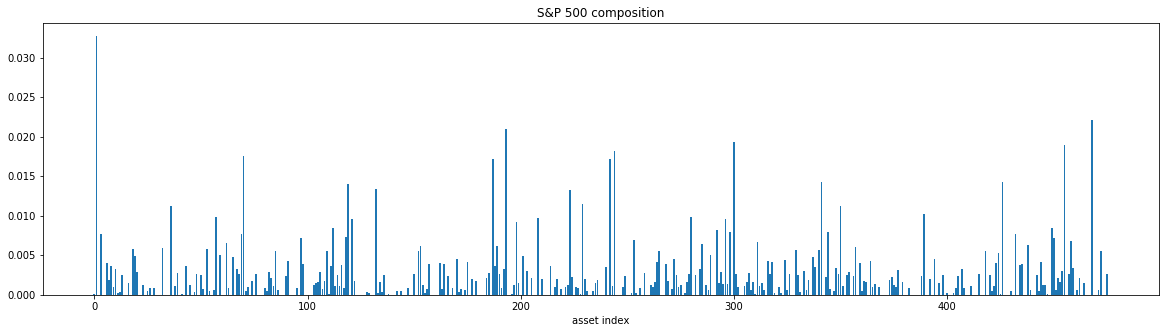

In [47]:
plt.figure(figsize=(20,5))

b_SP500 = b.value
_ = plt.bar(np.arange(len(b_SP500)), b_SP500)
_ = plt.xlabel("asset index")
_ = plt.title("S&P 500 composition")

#### Two-stage approach: weights proportional to b

In [48]:
K = 20
idx_Klargest = (np.argsort(b_SP500)[::-1])[:K]
s = np.zeros(N)
s[idx_Klargest] = 1

In [49]:
(np.argsort(b_SP500)[::-1])[:K]

array([  1, 468, 193, 300, 455, 244,  70, 187, 242, 426, 341, 119, 132,
       223, 229,  36, 350, 389,  57, 280])

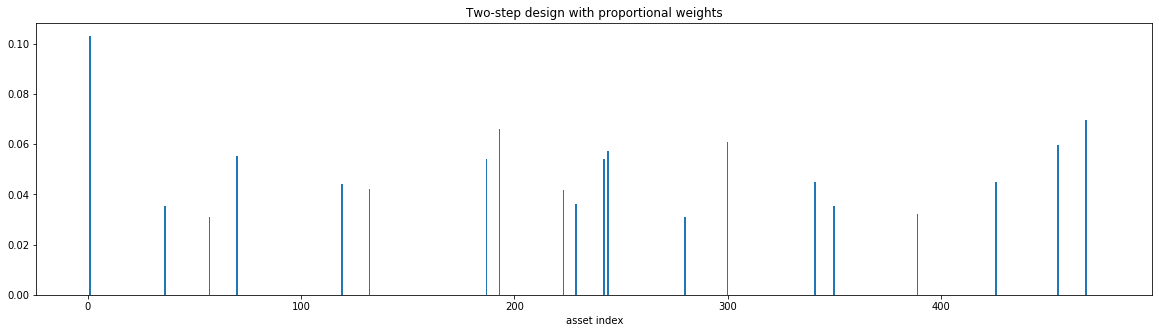

In [50]:
plt.figure(figsize=(20,5))

w_2step_a = np.zeros(N)
w_2step_a[idx_Klargest] = b_SP500[idx_Klargest]
w_2step_a = w_2step_a / np.sum(w_2step_a)
_ = plt.bar(np.arange(len(w_2step_a)), w_2step_a)
_ = plt.title("Two-step design with proportional weights")
_ = plt.xlabel("asset index")

#### Two-stage approach: fitted weights

In [51]:
w = cp.Variable(N)
obj = cp.Minimize(cp.sum((r_trn - X_trn @ (cp.multiply(w, s))) ** 2))
prob = cp.Problem(obj, constraints = [w >= 0, cp.sum(w) == 1])
prob.solve()

0.0031518568761936907

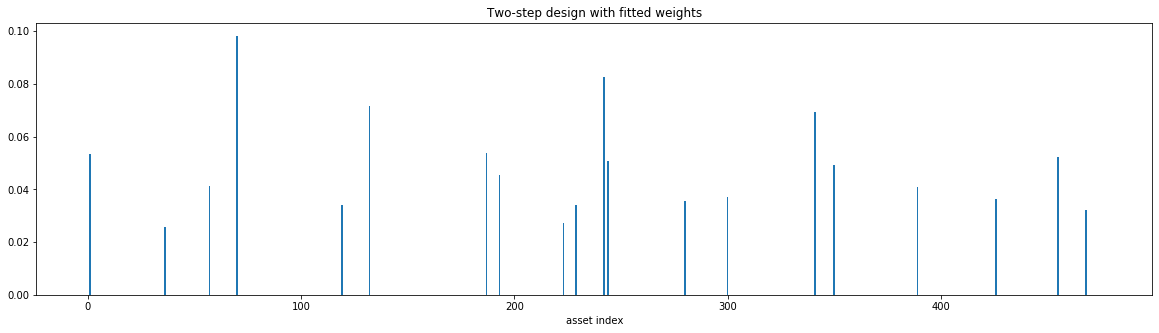

In [52]:
plt.figure(figsize=(20,5))

w_2step_b = w.value
plt.bar(np.arange(len(w_2step_b)), w_2step_b)
_ = plt.title("Two-step design with fitted weights")
_ = plt.xlabel("asset index")

# Sparse index tracking via MM (single majorization)

In [75]:
# parameters
gamma = 0.5
p = 1e-3  # parameters for the rho approximation of log
lamb = 6e-7  # this achieves a sparsity level of K=20
N = 476
# MM loop

w = np.ones(N)/N

obj_value = np.array([1/T_trn * np.linalg.norm(r_trn - X_trn @ w)**2 + lamb * np.sum(np.log(1+np.abs(w)/p)/np.log(1+gamma/p))])

while(True):
                  
    d = 1/(np.log(1+gamma/p)*(p+w))
    w_prev = w     
    
    w = cp.Variable(N)
    obj = cp.Minimize(1/T_trn * cp.sum_squares(r_trn - X_trn @ w) + lamb * d @ w)
                      
    prob = cp.Problem(obj, constraints = [w >= 0, cp.sum(w) == 1])
    result = prob.solve()   
    w = w.value
           
    obj_value = np.append(obj_value, 1/T_trn * np.linalg.norm(r_trn - X_trn @ w)**2 + lamb * np.sum(np.log(1+np.abs(w)/p)/np.log(1+gamma/p)))
  
    if(np.linalg.norm(w-w_prev)/np.linalg.norm(w_prev) < 1e-3):
        break

w_MM_single = w
                  


Text(0, 0.5, 'objective value')

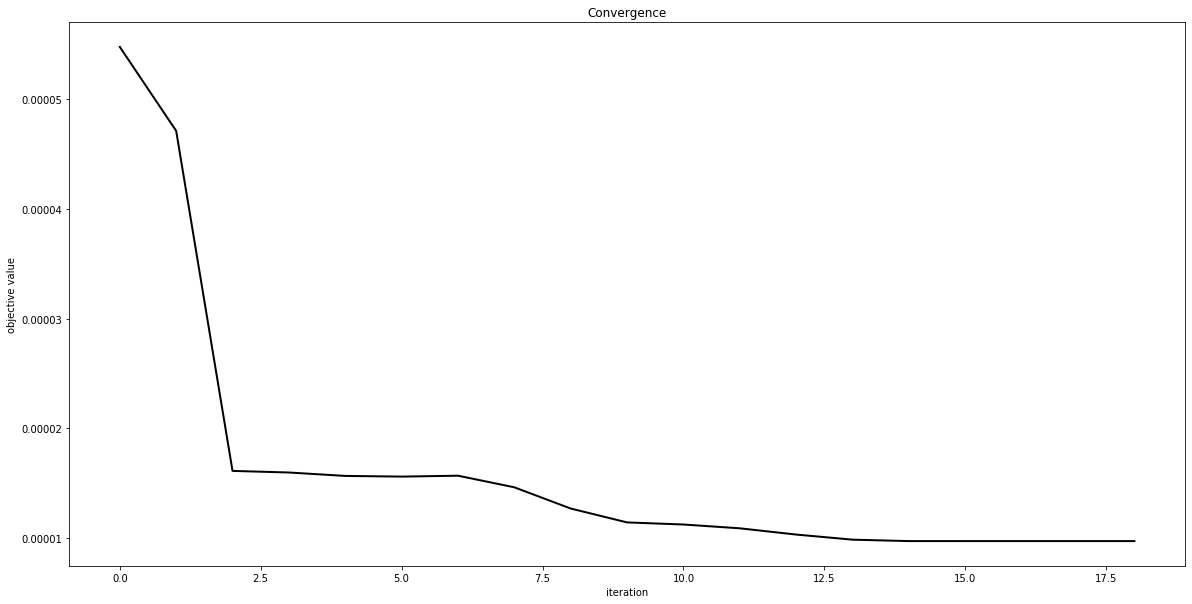

In [76]:
plt.figure(figsize=(20,10))

plt.plot(obj_value, lw=2, color='k')
plt.title('Convergence')
plt.xlabel('iteration')
plt.ylabel('objective value')

In [77]:
print("Sparsity level K =", np.sum(w_MM_single > 1e-2))

Sparsity level K = 20


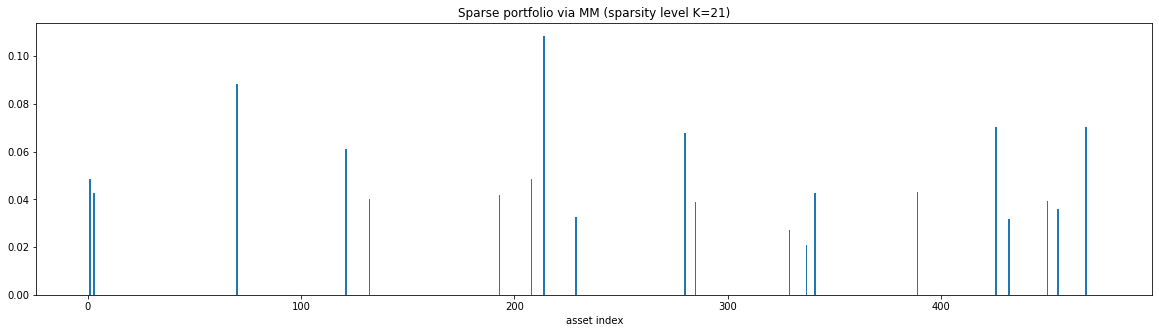

In [78]:
plt.figure(figsize=(20,5))

plt.bar(np.arange(len(w_MM_single)), w_MM_single)
_ = plt.title("Sparse portfolio via MM (sparsity level K=21)")
_ = plt.xlabel("asset index")


#### Comparison We can now compute the tracking errors of the two designs compared with the index value:¶

In [79]:
# tracking error
ETE = [(1/T)*np.linalg.norm(r_trn - X_trn @ b_SP500)**2,
       (1/T)*np.linalg.norm(r_trn - X_trn @ w_2step_a)**2,
       (1/T)*np.linalg.norm(r_trn - X_trn @ w_2step_b)**2,
       (1/T)*np.linalg.norm(r_trn - X_trn @ w_MM_single)**2,]

print(ETE)

[6.18295220141508e-08, 3.4965258965437247e-06, 2.3678068594831468e-06, 1.5927007491787414e-06]


Text(0.5, 1.0, 'Tracking error (in-sample)(K=20)')

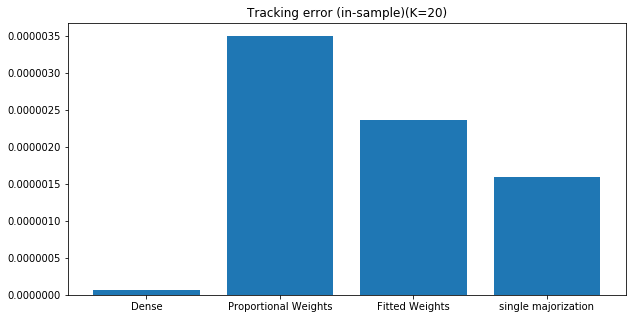

In [80]:
plt.figure(figsize=(10,5))

plt.bar(['Dense', 'Proportional Weights', 'Fitted Weights', 'single majorization'], ETE)
plt.title("Tracking error (in-sample)(K=20)")

In [81]:
# tracking error
ETE = [(1/T)*np.linalg.norm(r_tst - X_tst @ b_SP500)**2,
       (1/T)*np.linalg.norm(r_tst - X_tst @ w_2step_a)**2,
       (1/T)*np.linalg.norm(r_tst - X_tst @ w_2step_b)**2,
       (1/T)*np.linalg.norm(r_tst - X_tst @ w_MM_single)**2]

print(ETE)

[1.6537042580044572e-07, 1.151475895282291e-06, 1.2401171375923213e-06, 1.1892575585149081e-06]


Text(0.5, 1.0, 'Tracking error (out-sample)(K=20)')

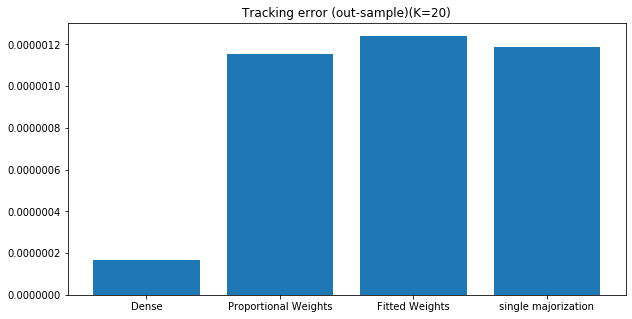

In [82]:
plt.figure(figsize=(10,5))

plt.bar(['Dense', 'Proportional Weights', 'Fitted Weights', 'single majorization'], ETE)
plt.title("Tracking error (out-sample)(K=20)")

In [90]:
returns_sp500 = r_trn
returns_dense = X_trn @ b_SP500
returns_a = X_trn @ w_2step_a
returns_b = X_trn @ w_2step_b
returns_mm = X_trn @ w_MM_single

In [91]:
sp500_PnL = np.array([1])
dense_PnL = np.array([1])
a_PnL = np.array([1])
b_PnL = np.array([1])
mm_PnL = np.array([1])


for i in returns_sp500:
    sp500_PnL = np.append(sp500_PnL, sp500_PnL[-1]*np.exp(i))
    
for i in returns_dense:
    dense_PnL = np.append(dense_PnL, dense_PnL[-1]*np.exp(i))
    
for i in returns_a:
    a_PnL = np.append(a_PnL, a_PnL[-1]*np.exp(i))
    
for i in returns_b:
    b_PnL = np.append(b_PnL, b_PnL[-1]*np.exp(i))
    
for i in returns_mm:
    mm_PnL = np.append(mm_PnL, mm_PnL[-1]*np.exp(i))
    
    

Text(0, 0.5, 'Normalized Return')

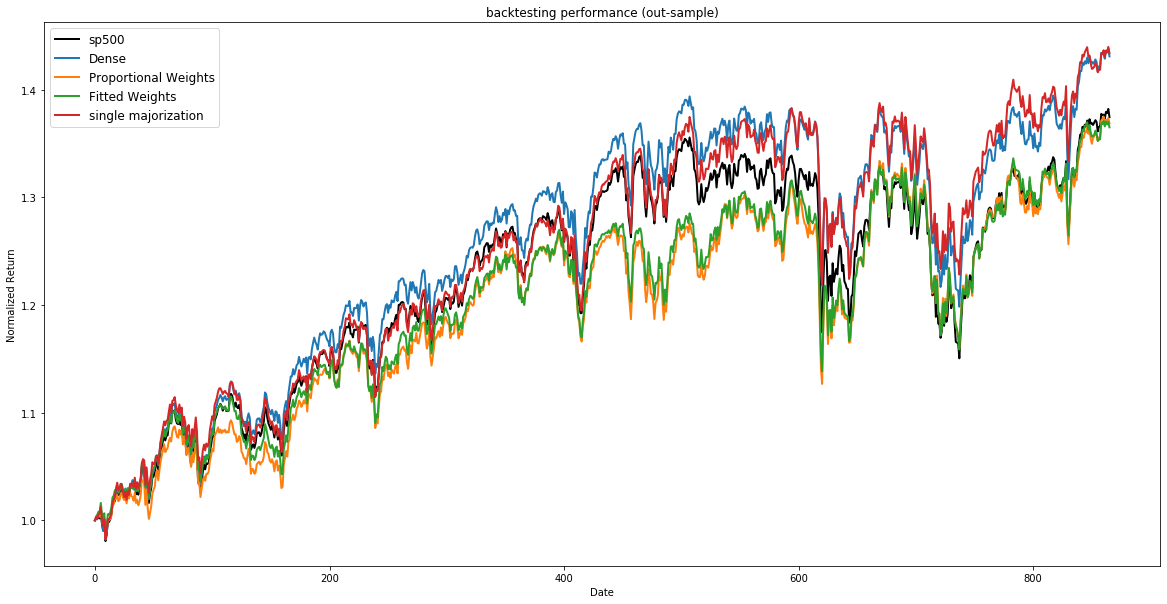

In [92]:
plt.figure(figsize=(20,10))

plt.plot(sp500_PnL, label='sp500', lw=2, color='k')
plt.plot(dense_PnL, lw=2, label='Dense')
plt.plot(a_PnL, lw=2, label='Proportional Weights')
plt.plot(b_PnL, lw=2, label='Fitted Weights')
plt.plot(mm_PnL, lw=2, label='single majorization')

# plt.plot(data.index[T_trn-1::], sp500_PnL, label='sp500', lw=2, color='k')
# plt.plot(data.index[T_trn-1::], dense_PnL, lw=2, label='Dense')
# plt.plot(data.index[T_trn-1::], a_PnL, lw=2, label='Proportional Weights')
# plt.plot(data.index[T_trn-1::], b_PnL, lw=2, label='Fitted Weights')
# plt.plot(data.index[T_trn-1::], mm_PnL, lw=2, label='single majorization')


plt.legend(loc='upper left', fontsize=12)
plt.title('backtesting performance (out-sample)')
plt.xlabel('Date')
plt.ylabel('Normalized Return')


In [93]:
returns_sp500 = r_tst
returns_dense = X_tst @ b_SP500
returns_a = X_tst @ w_2step_a
returns_b = X_tst @ w_2step_b
returns_mm = X_tst @ w_MM_single

In [94]:
sp500_PnL = np.array([1])
dense_PnL = np.array([1])
a_PnL = np.array([1])
b_PnL = np.array([1])
mm_PnL = np.array([1])


for i in returns_sp500:
    sp500_PnL = np.append(sp500_PnL, sp500_PnL[-1]*np.exp(i))
    
for i in returns_dense:
    dense_PnL = np.append(dense_PnL, dense_PnL[-1]*np.exp(i))
    
for i in returns_a:
    a_PnL = np.append(a_PnL, a_PnL[-1]*np.exp(i))
    
for i in returns_b:
    b_PnL = np.append(b_PnL, b_PnL[-1]*np.exp(i))
    
for i in returns_mm:
    mm_PnL = np.append(mm_PnL, mm_PnL[-1]*np.exp(i))
    
    

Text(0, 0.5, 'Normalized Return')

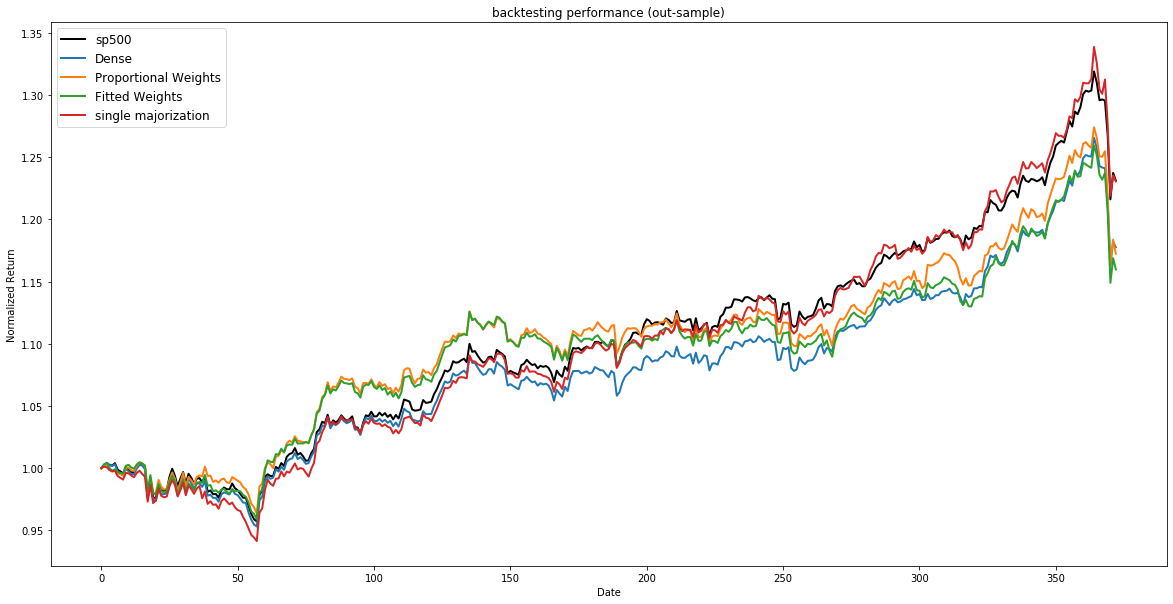

In [95]:
plt.figure(figsize=(20,10))

plt.plot(sp500_PnL, label='sp500', lw=2, color='k')
plt.plot(dense_PnL, lw=2, label='Dense')
plt.plot(a_PnL, lw=2, label='Proportional Weights')
plt.plot(b_PnL, lw=2, label='Fitted Weights')
plt.plot(mm_PnL, lw=2, label='single majorization')

# plt.plot(data.index[T_trn-1::], sp500_PnL, label='sp500', lw=2, color='k')
# plt.plot(data.index[T_trn-1::], dense_PnL, lw=2, label='Dense')
# plt.plot(data.index[T_trn-1::], a_PnL, lw=2, label='Proportional Weights')
# plt.plot(data.index[T_trn-1::], b_PnL, lw=2, label='Fitted Weights')
# plt.plot(data.index[T_trn-1::], mm_PnL, lw=2, label='single majorization')


plt.legend(loc='upper left', fontsize=12)
plt.title('backtesting performance (out-sample)')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
